In [1]:
import matplotlib.pyplot as plt
import itertools
import numpy as np


def plot_neural_input(res, position=15):
    plt.plot(res.e_.auditory_total_input[:, position], label="Auditory")
    plt.plot(res.e_.visual_total_input[:, position], label="Visual")
    plt.plot(res.e_.multi_total_input[:, position], label="Multisensory")
    plt.ylabel("Neural input", size=14)
    plt.xlabel("Time", size=14)
    plt.legend()
    plt.show()


def plot_res_per_soa(result_list, position=15):
    fig, axs = plt.subplots(3, 5, figsize=(16, 8), sharex=True, sharey=True)
    idx = -1
    for res in result_list:
        idx += 1
        row, col = idx // 5, idx % 5
        sub_plot = res.plot.linet(position=15, ax=axs[row, col])
        sub_plot.get_legend().remove()
        sub_plot.set_title("SOA " + str(int(res.run_params.soa)) + " ms")

    handles, labels = sub_plot.get_legend_handles_labels()
    fig.legend(handles, labels, loc="center right", borderaxespad=0.1)
    plt.subplots_adjust(right=0.935)
    plt.show()


def calculate_two_peaks_probability(visual_peaks_values):
    combinations = list(
        itertools.chain.from_iterable(
            itertools.combinations(visual_peaks_values, i + 2)
            for i in range(len(visual_peaks_values))
        )
    )

    probs_array = np.array([])

    for i in combinations:
        probs_array = np.append(probs_array, np.array(i).prod())

    return probs_array.sum() / probs_array.size


def compute_cost(model_data, exp_data):
    return np.sum(np.square(np.divide(exp_data - model_data, exp_data)))

In [2]:
from scipy.optimize import curve_fit


def sig(x, a, b, c, d):
    """Compute sigmoidal value for the given delay.
    Args:
        x (1D np.array): Delay (ms).
        a (number): upper asymptote of the sigmoid.
        b (number): lower asymptote of the sigmoid.
        c (number): Central point of the sigmoid.
        d (number): Slope parameter of the sigmoid (slope = 1/d).

    Returns:
        sig (1D np.array): Vector with values for the given delay points.
    """
    return a + b / (1 + np.exp(-(x - c) / d))


## Sigmoid function fitting
def sigfit(x, y):
    """Fit the RT data to a sigmoidal function.

    Args:
        x (1D np.array): Delay (ms).
        y (1D np.array) : Values for the given delay points.

    Returns:
        a (number): upper asymptote of the sigmoid.
        b (number): lower asymptote of the sigmoid.
        c (number): Central point of the sigmoid.
        d (number): Slope parameter of the sigmoid (slope = 1/d).
    """

    # Obtains the upper and lower bounds
    a = np.max(y)
    b = np.min(y)

    # Defines starting points and boundaries for the fitting
    k_0 = (a - b) / (x[-1] - x[0])
    initial_slope = -(a - b) / (4 * k_0)
    # if initial_slope>=0: initial_slope=-0.0001
    middle_x = np.max(x) / 2
    init_guess = [a, b, middle_x, initial_slope]
    boundaries = ([0, 0, 36, float("-inf")], [100, 100, 204, 0])

    # Fits the data
    popt, _ = curve_fit(
        sig,
        x,
        y,
        p0=init_guess,
        method="trf",
        ftol=1e-8,
        xtol=1e-8,
        maxfev=100000,
        bounds=boundaries,
    )
    sigpar = np.asarray(popt)
    a = sigpar[0]
    b = sigpar[1]
    c = sigpar[2]
    d = sigpar[3]

    return a, b, c, d

## Parameters sweep

In [5]:
from skneuromsi.neural import Paredes2022
from joblib import Parallel, delayed
import numpy as np
from findpeaks import findpeaks


def myjob_explore(
    soa, l_ex, fb_weight, cm_weight, ff_pruning_threshold, cm_pruning_threshold
):
    model = Paredes2022(
        time_range=(0, 500),
        neurons=30,
        position_range=(0, 30),
        tau=(a_tau, v_tau, m_tau),
    )
    res = model.run(
        auditory_intensity=2.425,
        visual_intensity=1.375,
        auditory_stim_n=2,
        visual_stim_n=1,
        auditory_duration=7,
        visual_duration=12,
        soa=soa,
        noise=False,
        cross_modal_weight=cm_weight,
        feedback_weight=fb_weight,
        feedforward_weight=ff_weight,
        lateral_excitation=l_ex,
        feedforward_pruning_threshold=ff_pruning_threshold,
        cross_modal_pruning_threshold=cm_pruning_threshold,
    )

    fp = findpeaks(method="topology", verbose=0, limit=0.15)
    fp_results = fp.fit(res.get_modes("visual").query("positions==15").visual.values)
    visual_peaks_df = fp_results["df"].query("peak==True & valley==False")
    if visual_peaks_df["score"].size < 2:
        p_two_flashes = 0
    else:
        p_two_flashes = calculate_two_peaks_probability(visual_peaks_df["y"].values)
    multi_fp_results = fp.fit(
        res.get_modes("multi").query("positions==15").multi.values
    )
    multi_peaks_df = multi_fp_results["df"].query("peak==True & valley==False")
    if multi_peaks_df["score"].size < 2:
        p_two_causes = 0
    else:
        p_two_causes = calculate_two_peaks_probability(multi_peaks_df["y"].values)
    return p_two_flashes, res, p_two_causes

#### Lateral excitation

In [6]:
# Fitted L-SPQ model parameters
cm_weight, fb_weight, ff_weight, a_tau, v_tau, m_tau = (
    1.106e-03,
    3.713e-01,
    2.843e00,
    6.743e00,
    1.591e01,
    6.451e01,
)

soas = np.linspace(36, 204, 15)
lex_values = np.linspace(1.90, 2.15, 3)

raw_model_data_per_lex = []
tbw_per_lex = []
res_per_lex = []
causes_per_lex = []
opi_per_lex = []

for lex in lex_values:
    with Parallel(n_jobs=-1) as parallel:
        par_res = parallel(
            delayed(myjob_explore)(soa, lex, fb_weight, cm_weight, 0, 0) for soa in soas
        )

    p_two_flashes = [i[0] for i in par_res]
    raw_model_data = np.array(p_two_flashes) * 100
    raw_model_data_per_lex.append(raw_model_data)

    res = [i[1] for i in par_res]
    res_per_lex.append(res)

    _, _, tbw, _ = sigfit(soas, raw_model_data)
    tbw_per_lex.append(tbw)

    p_two_causes = [i[2] for i in par_res]
    p_two_causes_average = np.average(np.array(p_two_causes))
    p_unity = 1 - p_two_causes_average
    causes_per_lex.append(p_unity)

    opi = np.average(raw_model_data)
    opi_per_lex.append(opi)

Text(0.5, 0, 'L_ex')

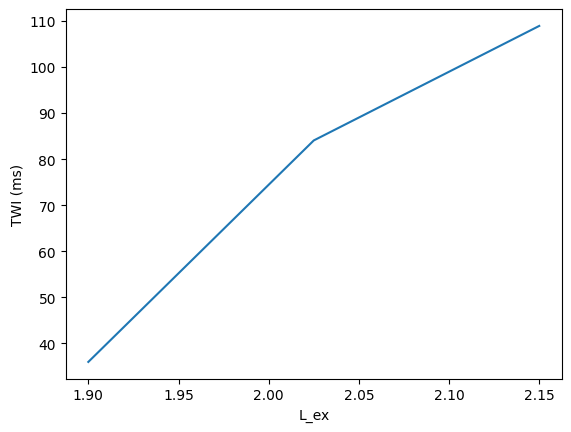

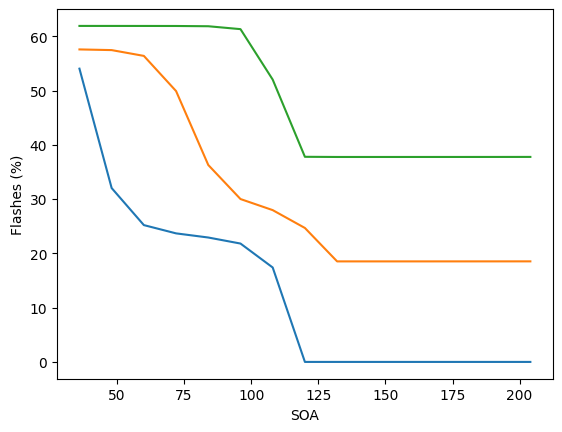

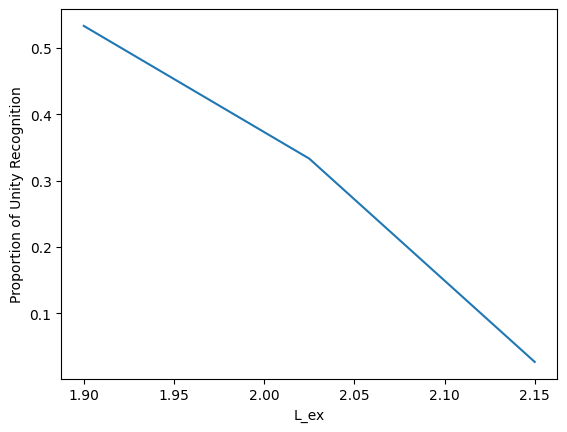

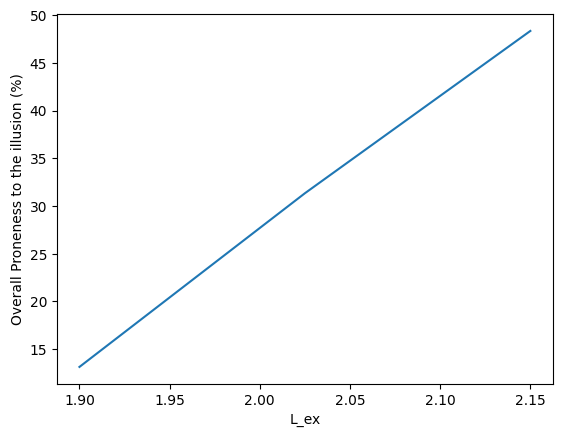

In [8]:
plt.figure(1)
plt.plot(lex_values, tbw_per_lex)
plt.ylabel("TWI (ms)")
plt.xlabel("L_ex")

plt.figure(2)
plt.plot(soas, np.array(raw_model_data_per_lex).T)
plt.ylabel("Flashes (%)")
plt.xlabel("SOA")

plt.figure(3)
plt.plot(lex_values, causes_per_lex)
plt.ylabel("Proportion of Unity Recognition")
plt.xlabel("L_ex")

plt.figure(4)
plt.plot(lex_values, opi_per_lex)
plt.ylabel("Overall Proneness to the illusion (%)")
plt.xlabel("L_ex")

#### Feedback weight

In [6]:
cm_weight, fb_weight, ff_weight, a_tau, v_tau, m_tau = (
    1.106e-03,
    3.713e-01,
    2.843e00,
    6.743e00,
    1.591e01,
    6.451e01,
)

soas = np.linspace(36, 204, 15)
fb_weight_values = np.linspace(0.35, 0.4, 3)

raw_model_data_per_fb_weight = []
tbw_per_fb_weight = []
res_per_fb_weight = []
causes_per_fb_weight = []
opi_per_fb_weight = []

for fb_weight in fb_weight_values:
    with Parallel(n_jobs=-1) as parallel:
        par_res = parallel(
            delayed(myjob_explore)(soa, 2, fb_weight, cm_weight, 0, 0) for soa in soas
        )

    p_two_flashes = [i[0] for i in par_res]
    raw_model_data = np.array(p_two_flashes) * 100
    raw_model_data_per_fb_weight.append(raw_model_data)

    res = [i[1] for i in par_res]
    res_per_fb_weight.append(res)

    _, _, tbw, _ = sigfit(soas, raw_model_data)
    tbw_per_fb_weight.append(tbw)

    p_two_causes = [i[2] for i in par_res]
    p_two_causes_average = np.average(np.array(p_two_causes))
    p_unity = 1 - p_two_causes_average
    causes_per_fb_weight.append(p_unity)

    opi = np.average(raw_model_data)
    opi_per_fb_weight.append(opi)

Text(0.5, 0, 'FB_weight')

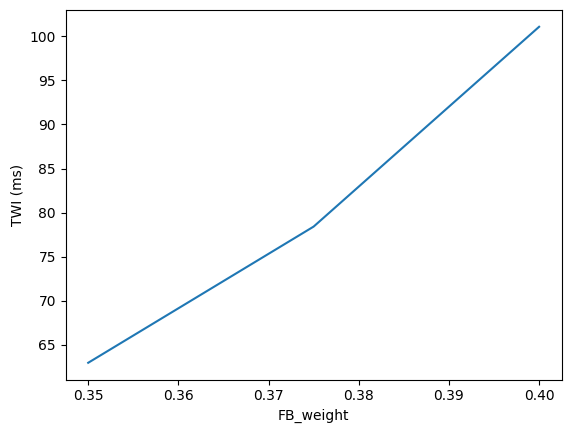

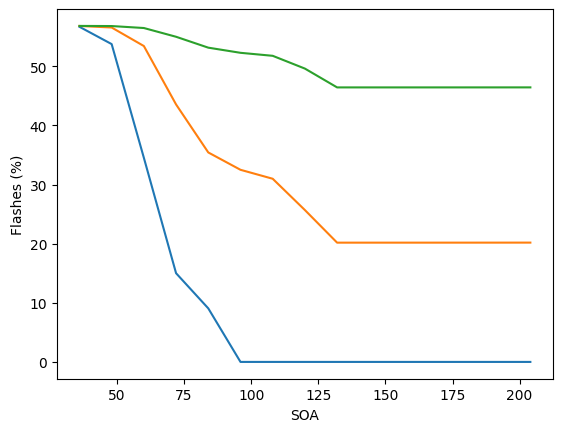

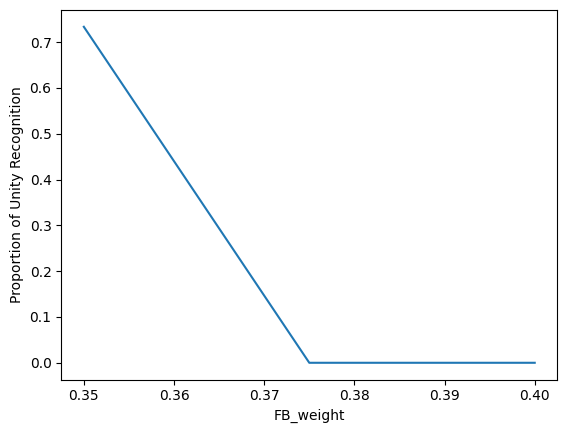

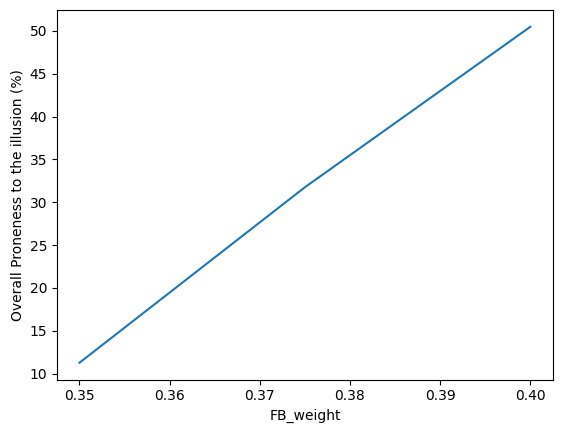

In [7]:
plt.figure(1)
plt.plot(fb_weight_values, tbw_per_fb_weight)
plt.ylabel("TWI (ms)")
plt.xlabel("FB_weight")

plt.figure(2)
plt.plot(soas, np.array(raw_model_data_per_fb_weight).T)
plt.ylabel("Flashes (%)")
plt.xlabel("SOA")

plt.figure(3)
plt.plot(fb_weight_values, causes_per_fb_weight)
plt.ylabel("Proportion of Unity Recognition")
plt.xlabel("FB_weight")

plt.figure(4)
plt.plot(fb_weight_values, opi_per_fb_weight)
plt.ylabel("Overall Proneness to the illusion (%)")
plt.xlabel("FB_weight")

## Cross-modal weight

In [8]:
cm_weight, fb_weight, ff_weight, a_tau, v_tau, m_tau = (
    1.106e-03,
    3.713e-01,
    2.843e00,
    6.743e00,
    1.591e01,
    6.451e01,
)

soas = np.linspace(36, 204, 15)
cm_weight_values = np.linspace(0, 0.275, 3)

raw_model_data_per_cm_weight = []
tbw_per_cm_weight = []
res_per_cm_weight = []
causes_per_cm_weight = []
opi_per_cm_weight = []

for cm_weight in cm_weight_values:
    with Parallel(n_jobs=-1) as parallel:
        par_res = parallel(
            delayed(myjob_explore)(soa, 2, fb_weight, cm_weight, 0, 0) for soa in soas
        )

    p_two_flashes = [i[0] for i in par_res]
    raw_model_data = np.array(p_two_flashes) * 100
    raw_model_data_per_cm_weight.append(raw_model_data)

    res = [i[1] for i in par_res]
    res_per_cm_weight.append(res)

    _, _, tbw, _ = sigfit(soas, raw_model_data)
    tbw_per_cm_weight.append(tbw)

    p_two_causes = [i[2] for i in par_res]
    p_two_causes_average = np.average(np.array(p_two_causes))
    p_unity = 1 - p_two_causes_average
    causes_per_cm_weight.append(p_unity)

    opi = np.average(raw_model_data)
    opi_per_cm_weight.append(opi)

Text(0.5, 0, 'CM_weight')

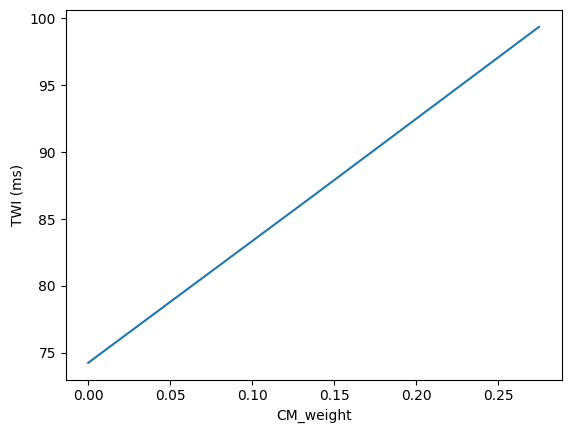

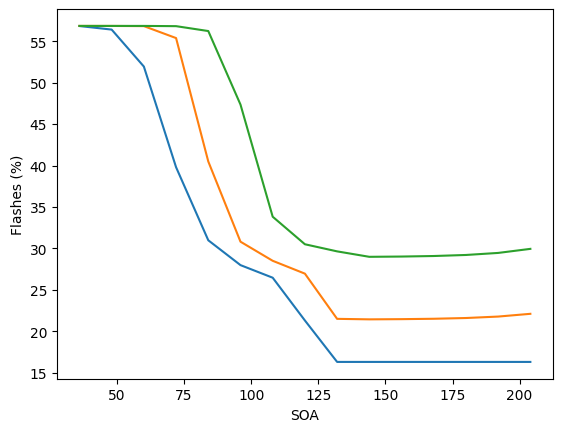

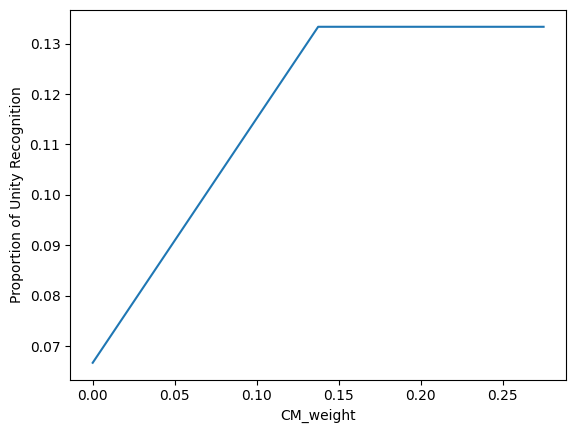

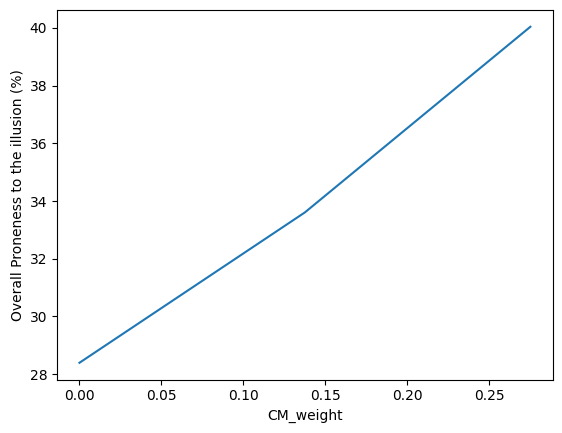

In [9]:
plt.figure(1)
plt.plot(cm_weight_values, tbw_per_cm_weight)
plt.ylabel("TWI (ms)")
plt.xlabel("CM_weight")

plt.figure(2)
plt.plot(soas, np.array(raw_model_data_per_cm_weight).T)
plt.ylabel("Flashes (%)")
plt.xlabel("SOA")

plt.figure(3)
plt.plot(cm_weight_values, causes_per_cm_weight)
plt.ylabel("Proportion of Unity Recognition")
plt.xlabel("CM_weight")

plt.figure(4)
plt.plot(cm_weight_values, opi_per_cm_weight)
plt.ylabel("Overall Proneness to the illusion (%)")
plt.xlabel("CM_weight")

## Feedforward pruning

In [18]:
cm_weight, fb_weight, ff_weight, a_tau, v_tau, m_tau = (
    1.106e-03,
    3.713e-01,
    2.843e00,
    6.743e00,
    1.591e01,
    6.451e01,
)

soas = np.linspace(36, 204, 15)
ff_pruning_values = np.linspace(0, ff_weight, 3)

raw_model_data_per_ff_pruning = []
tbw_per_ff_pruning = []
res_per_ff_pruning = []
causes_per_ff_pruning = []
opi_per_ff_pruning = []

for ff_pruning in ff_pruning_values:
    with Parallel(n_jobs=-2) as parallel:
        par_res = parallel(
            delayed(myjob_explore)(soa, 2, fb_weight, cm_weight, ff_pruning, 0)
            for soa in soas
        )

    p_two_flashes = [i[0] for i in par_res]
    raw_model_data = np.array(p_two_flashes) * 100
    raw_model_data_per_ff_pruning.append(raw_model_data)

    res = [i[1] for i in par_res]
    res_per_ff_pruning.append(res)

    _, _, tbw, _ = sigfit(soas, raw_model_data)
    tbw_per_ff_pruning.append(tbw)

    p_two_causes = [i[2] for i in par_res]
    p_two_causes_average = np.average(np.array(p_two_causes))
    p_unity = 1 - p_two_causes_average
    causes_per_ff_pruning.append(p_unity)

    opi = np.average(raw_model_data)
    opi_per_ff_pruning.append(opi)

Text(0.5, 0, 'Feedforward Pruning')

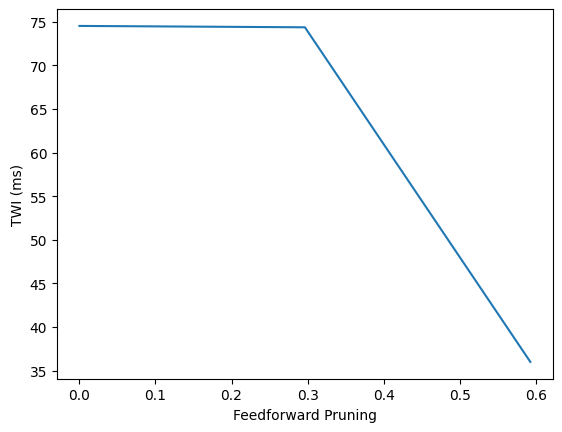

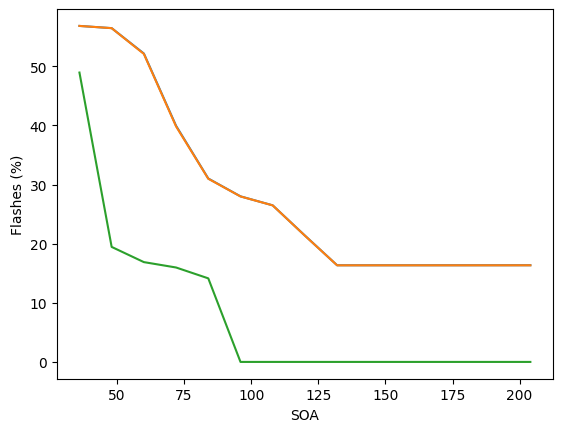

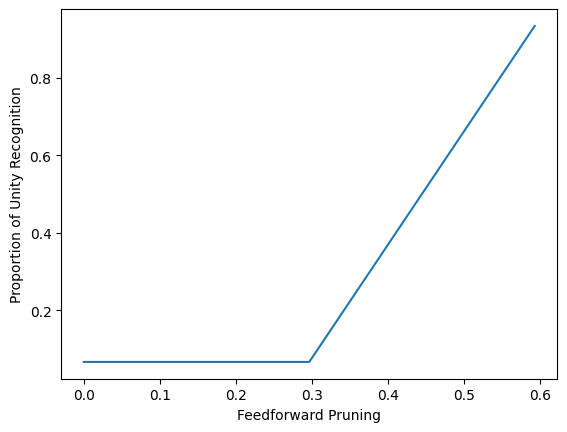

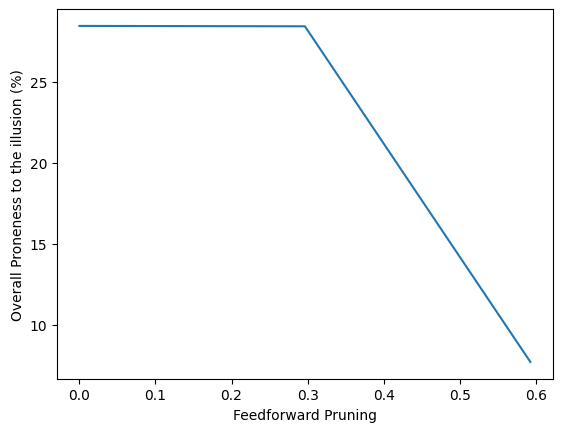

In [19]:
plt.figure(1)
plt.plot(ff_pruning_values, tbw_per_ff_pruning)
plt.ylabel("TWI (ms)")
plt.xlabel("Feedforward Pruning")

plt.figure(2)
plt.plot(soas, np.array(raw_model_data_per_ff_pruning).T)
plt.ylabel("Flashes (%)")
plt.xlabel("SOA")

plt.figure(3)
plt.plot(ff_pruning_values, causes_per_ff_pruning)
plt.ylabel("Proportion of Unity Recognition")
plt.xlabel("Feedforward Pruning")

plt.figure(4)
plt.plot(ff_pruning_values, opi_per_ff_pruning)
plt.ylabel("Overall Proneness to the illusion (%)")
plt.xlabel("Feedforward Pruning")

In [20]:
cm_weight, fb_weight, ff_weight, a_tau, v_tau, m_tau = (
    1.106e-03,
    3.713e-01,
    2.843e00,
    6.743e00,
    1.591e01,
    6.451e01,
)

soas = np.linspace(36, 204, 15)
cm_pruning_values = np.linspace(0, cm_weight, 3)

raw_model_data_per_cm_pruning = []
tbw_per_cm_pruning = []
res_per_cm_pruning = []
causes_per_cm_pruning = []
opi_per_cm_pruning = []

for cm_pruning in cm_pruning_values:
    with Parallel(n_jobs=-2) as parallel:
        par_res = parallel(
            delayed(myjob_explore)(soa, 2, fb_weight, cm_weight, 0, cm_pruning)
            for soa in soas
        )

    p_two_flashes = [i[0] for i in par_res]
    raw_model_data = np.array(p_two_flashes) * 100
    raw_model_data_per_cm_pruning.append(raw_model_data)

    res = [i[1] for i in par_res]
    res_per_cm_pruning.append(res)

    _, _, tbw, _ = sigfit(soas, raw_model_data)
    tbw_per_cm_pruning.append(tbw)

    p_two_causes = [i[2] for i in par_res]
    p_two_causes_average = np.average(np.array(p_two_causes))
    p_unity = 1 - p_two_causes_average
    causes_per_cm_pruning.append(p_unity)

    opi = np.average(raw_model_data)
    opi_per_cm_pruning.append(opi)

Text(0.5, 0, 'Feedforward Pruning')

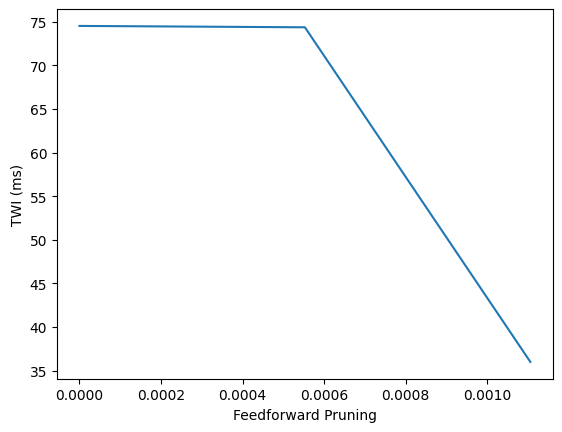

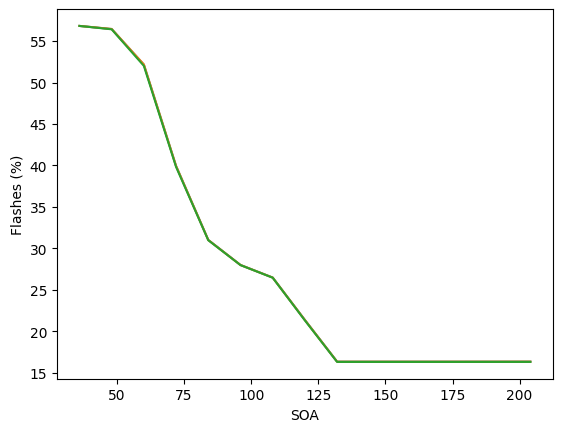

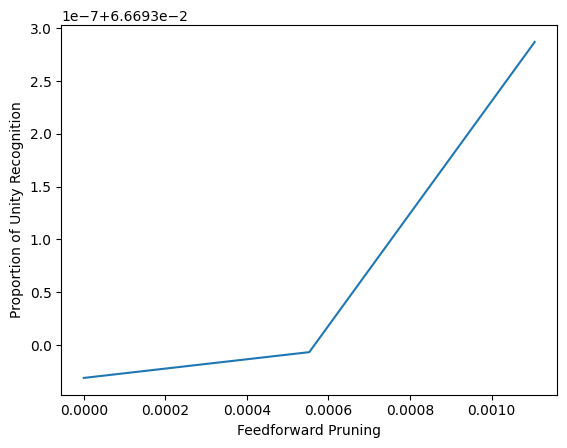

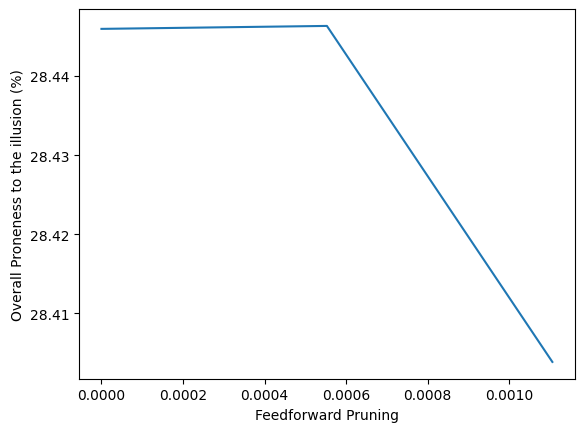

In [21]:
plt.figure(1)
plt.plot(cm_pruning_values, tbw_per_ff_pruning)
plt.ylabel("TWI (ms)")
plt.xlabel("Feedforward Pruning")

plt.figure(2)
plt.plot(soas, np.array(raw_model_data_per_cm_pruning).T)
plt.ylabel("Flashes (%)")
plt.xlabel("SOA")

plt.figure(3)
plt.plot(cm_pruning_values, causes_per_cm_pruning)
plt.ylabel("Proportion of Unity Recognition")
plt.xlabel("Feedforward Pruning")

plt.figure(4)
plt.plot(cm_pruning_values, opi_per_cm_pruning)
plt.ylabel("Overall Proneness to the illusion (%)")
plt.xlabel("Feedforward Pruning")

# Plot

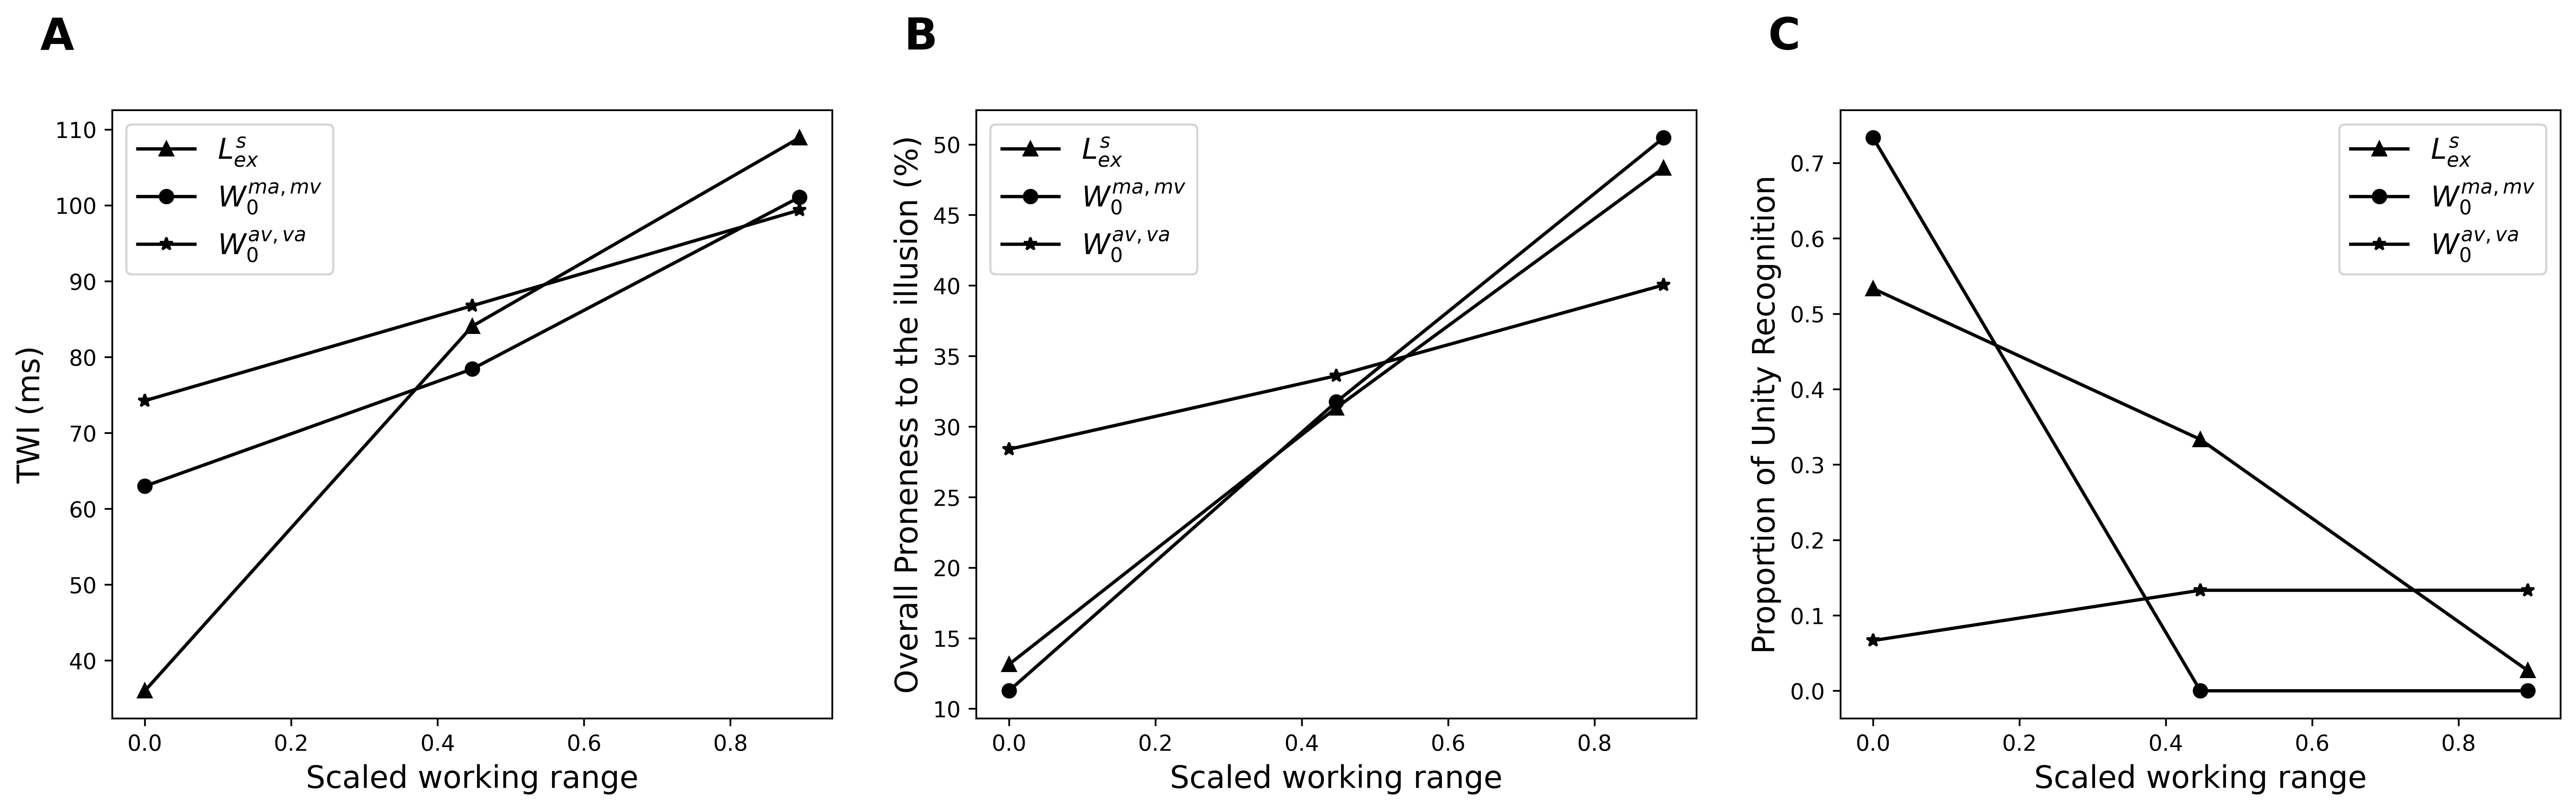

: 

In [29]:
from sklearn.preprocessing import normalize
import string

norm_lex_values = normalize(lex_values.reshape(1, -1))[0]
norm_fb_weight_values = normalize(fb_weight_values.reshape(1, -1))[0]
norm_cm_weight_values = normalize(cm_weight_values.reshape(1, -1))[0]

fig, axs = plt.subplots(1, 3, figsize=(20, 5), dpi=600)
size = 5

ax1 = plt.subplot(131)
ax1.plot(
    norm_cm_weight_values, tbw_per_lex, label=r"$L_{ex}^{s}$", color="k", marker="^"
)
ax1.plot(
    norm_cm_weight_values,
    tbw_per_fb_weight,
    label=r"$W_{0}^{ma, mv}$",
    color="k",
    marker="o",
)
ax1.plot(
    norm_cm_weight_values,
    tbw_per_cm_weight,
    label=r"$W_{0}^{av, va}$",
    color="k",
    marker="*",
)
# ax1.plot(np.linspace(0,.75,size),np.repeat(70.38,size),'--',label='SCZ',color='0.5')
# ax1.plot(np.linspace(0,.75,size),np.repeat(73.75,size),':',label='H-SPQ',color='0.5')
ax1.set_ylabel("TWI (ms)", size=14)
ax1.set_xlabel("Scaled working range", size=14)
leg = ax1.legend(fontsize=13)
ax1.text(
    -0.1,
    1.1,
    string.ascii_uppercase[0],
    transform=ax1.transAxes,
    size=20,
    weight="bold",
)

ax3 = plt.subplot(132)
ax3.plot(
    norm_cm_weight_values, opi_per_lex, label=r"$L_{ex}^{s}$", color="k", marker="^"
)
ax3.plot(
    norm_cm_weight_values,
    opi_per_fb_weight,
    label=r"$W_{0}^{ma, mv}$",
    color="k",
    marker="o",
)
ax3.plot(
    norm_cm_weight_values,
    opi_per_cm_weight,
    label=r"$W_{0}^{av, va}$",
    color="k",
    marker="*",
)
ax3.set_ylabel("Overall Proneness to the illusion (%)", size=14)
ax3.set_xlabel("Scaled working range", size=14)
leg = ax3.legend(fontsize=13)
ax3.text(
    -0.1,
    1.1,
    string.ascii_uppercase[1],
    transform=ax3.transAxes,
    size=20,
    weight="bold",
)

ax3 = plt.subplot(133)
ax3.plot(
    norm_cm_weight_values, causes_per_lex, label=r"$L_{ex}^{s}$", color="k", marker="^"
)
ax3.plot(
    norm_cm_weight_values,
    causes_per_fb_weight,
    label=r"$W_{0}^{ma, mv}$",
    color="k",
    marker="o",
)
ax3.plot(
    norm_cm_weight_values,
    causes_per_cm_weight,
    label=r"$W_{0}^{av, va}$",
    color="k",
    marker="*",
)
ax3.set_ylabel("Proportion of Unity Recognition", size=14)
ax3.set_xlabel("Scaled working range", size=14)
leg = ax3.legend(fontsize=13)
ax3.text(
    -0.1,
    1.1,
    string.ascii_uppercase[2],
    transform=ax3.transAxes,
    size=20,
    weight="bold",
)

fig.savefig("drafts/FIG2.eps", bbox_inches="tight", format="eps")